Import Libraries

In [16]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


Define the constants and initial conditions

In [17]:
length = 1e-2                     # Length of the rod


# Material properties

rho_l = 2680                 # Density of Aluminium (kg/m^3) in liquid state
rho_m = 2680                 # Density of Aluminium (kg/m^3) in mushy state
rho_s = 2680                # Density of Aluminium (kg/m^3) in solid state
k_m =     113                    # W/m-K Thermal Conductivity inMushy zone
k_l =     113                   # W/m-K Thermal Conductivity in Liquid zone
k_s =     113                    # W/m-K Thermal Conductivity in Solid zone
cp_m =     963                   # Specific heat of aluminum (J/kg-K) in mushy zone
cp_l =    963                    # Specific heat of aluminum (J/kg-K) in liquid zone
cp_s =      963                  # Specific heat of aluminum (J/kg-K)  in solid zone
alpha_m = k_m / (rho_m * cp_m)            # Thermal diffusivity 
alpha_l = k_l / (rho_l * cp_l)    # Thermal diffusivity of liquid phase
alpha_s = k_s / (rho_s * cp_s)    # Thermal diffusivity of solid phase
#print(alpha)

#L_fusion = 3.9e3                 # J/kg
L_frz = 389e3               # J/kg


# Initial Conditions
T_L = 866.0                       #  K -Liquidus Temperature (593 c)
T_S = 811.0                       # K- Solidus Temperature (538 C)



# Spatial discretization


num_points = 50                  # Number of spatial points
dx = length / (num_points - 1)
print(dx)
                                   #dt = time_end/num_steps
num_steps = 100            # Number of time steps
                                  # num_steps = round(time_end/dt)
                                                              
# Time Discretization  
time_end = 2                # seconds                         
#num_steps = 10000
# dt = time_end/num_steps

dt = abs(0.5 *(dx**2/alpha_m))
num_steps = round(time_end/dt) +1
print('num_steps is',num_steps)
print('dt is ',dt)

cfl = 0.5 *(dx**2/alpha_m)
print('cfl is',cfl)
dt = time_end / num_steps
time_steps = np.linspace(0, time_end, num_steps + 1)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

0.00020408163265306123
num_steps is 4206
dt is  0.00047562040890042134
cfl is 0.00047562040890042134
stability criteria satisfied


Defining the simulation field and initilisation of the temperatures

In [18]:
# Initial temperature and phase fields
temperature = np.full(num_points, 870.0)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
temperature[-1] = 313.0 #(40 C)
phase[-1] = 0.0

temperature[0] = 313.0 #(40 C)
phase[0] = 0


# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

print(temperature_history,phi_history)

[array([313., 870., 870., 870., 870., 870., 870., 870., 870., 870., 870.,
       870., 870., 870., 870., 870., 870., 870., 870., 870., 870., 870.,
       870., 870., 870., 870., 870., 870., 870., 870., 870., 870., 870.,
       870., 870., 870., 870., 870., 870., 870., 870., 870., 870., 870.,
       870., 870., 870., 870., 870., 313.])] [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]


Solving the heat transfer equation and phase change using numerical methods

In [19]:
# Finite difference method

for m in range(1, num_steps+1):                  # time loop
    for n in range(1,num_points-1):              # space loop, adjusted range
        #print(f"Step {m}, space{n},Temperature: {temperature}, Phase: {phase}")
        temp_n = temperature[n]
        c1_val = np.max(temp_n - T_L,0) / (temperature[n]- T_L)
        c2_val = np.max(T_S - temp_n,0) / (T_S - temperature[n])
        c3_val = (1-c1_val)*(1-c2_val)
        d2T_dx2 = (temperature[n+1] - 2*temperature[n] + temperature[n-1]) / dx**2
        temperature[n] += ((c1_val*alpha_l)+(c2_val*alpha_s)+(c3_val*(k_m/rho_m*(cp_m-(L_frz/(T_L-T_S)))))) * dt * d2T_dx2
        phase[n] = np.clip((T_L - temp_n)/(T_L-T_S),0,1)
    temperature_history.append(temperature.copy())
    phi_history.append(phase.copy())
    #Print for debugging
    


#print(temperature_history)
#print(phi_history)




Plot the Results

Temperature History Shape: (4207, 50)
Phi History Shape: (4207, 50)
Transposed Temperature History Shape: (4207, 50)
Transposed Phi History Shape: (4207, 50)


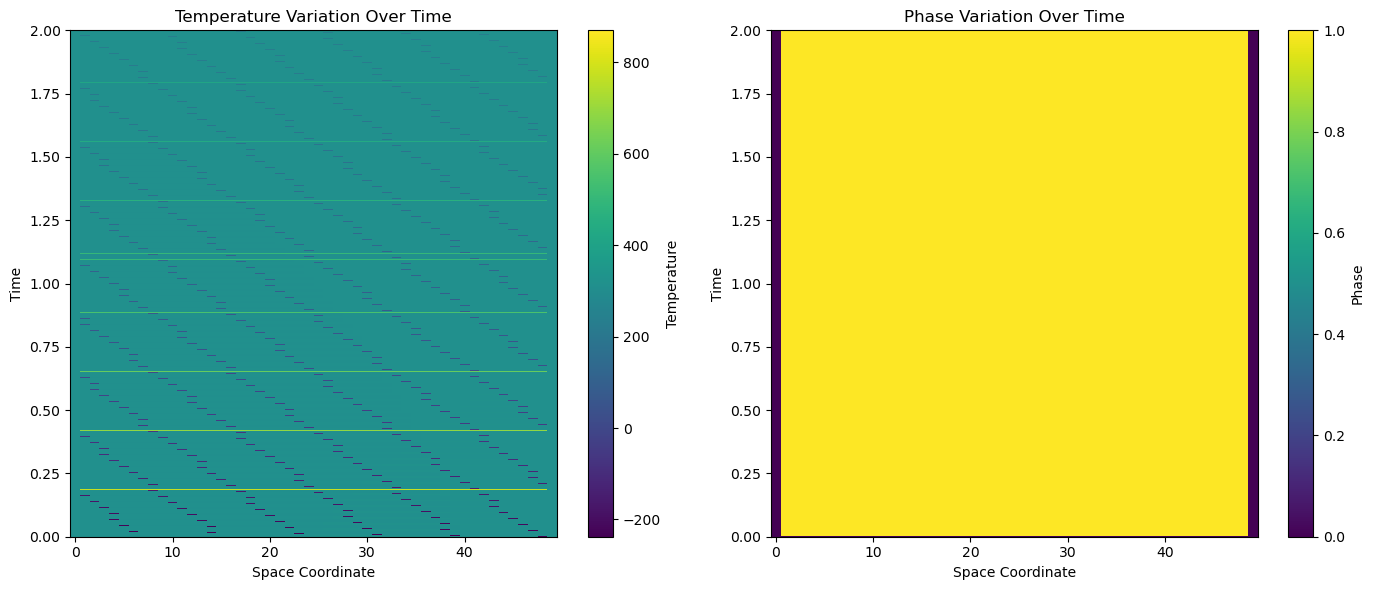

In [20]:
# Assuming you have temperature_history and phi_history as lists of arrays
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)

# Check the shape of temperature_history and phi_history
print("Temperature History Shape:", temperature_history.shape)
print("Phi History Shape:", phi_history.shape)

# Assuming temperature_history and phi_history have dimensions (time, space)
# # If needed, transpose the arrays to match the expected dimensions of pcolormesh
# temperature_history = temperature_history.T
# phi_history = phi_history.T

# Check the new shape after transposing
print("Transposed Temperature History Shape:", temperature_history.shape)
print("Transposed Phi History Shape:", phi_history.shape)

# Create a meshgrid for space and time coordinates
space_coord, time_coord = np.meshgrid(np.arange(temperature_history.shape[1]), np.arange(temperature_history.shape[0]))
time_coord = time_coord * dt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, temperature_history, cmap='viridis')
ax1.set_xlabel('Space Coordinate')
ax1.set_ylabel('Time')
ax1.set_title('Temperature Variation Over Time')
fig.colorbar(im1, ax=ax1, label='Temperature')

# Plot the phase history on the right subplot
im2 = ax2.pcolormesh(space_coord, time_coord, phi_history, cmap='viridis')
ax2.set_xlabel('Space Coordinate')
ax2.set_ylabel('Time')
ax2.set_title('Phase Variation Over Time')
fig.colorbar(im2, ax=ax2, label='Phase')
plt.tight_layout()
plt.show()